# Roman Spectroscopy Demo -- Grism Spectral Extraction

In this notebook, we demonstrate an example workflow one can follow to extract the grism spectra from Roman images. We will use simulated grism data for this exercise and illustrate how to go from a full 2D grism dispersed image to a 1D spectrum for a source of interest.


**-- Important Disclaimer --** 

This workflow is vastly simplified for the purposes of demonstration. This does not represent the full functionality available from the Grism/Prism Data Processing System (GDPS) which is the full pipeline that will be implemented for reducing the Roman spectral data, that includes several additional features. In the limited demonstration showcased here, we will be making several simplifying assumptions, which will be highlighted by **NOTES** throughout the notebook.

#### Initial setup, imports and utility functions

Let's begin with the initial set of imports and a couple utility functions that will be used throughout the notebook.

In [1]:
import asdf
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import numpy as np

from astropy.table import Table
from scipy.ndimage import rotate
from scipy.interpolate import interp1d
from matplotlib.patches import Circle, Rectangle
from astropy.nddata import Cutout2D
from itertools import cycle
from astropy.convolution import convolve
from photutils.segmentation import detect_sources

%matplotlib inline

def get_vmin_vmax(img, fac_neg=1.5, fac_pos=3):
    """
    Returns a min-max value to scale images (when plotting)
    """
    med, std = np.nanmedian(img), np.nanstd(img)
    vmin = med - fac_neg * std
    vmax = med + fac_pos * std
    return vmin, vmax

def cutout_image(image, position, size, fill_value=0):
    """
    Uses the astropy Cutout2D to cutout a part of the image
    """
    return Cutout2D(image, position, size=size, mode="partial", fill_value=fill_value).data

### Simulated Grism Spectroscopy Data

For this showcase, we will utilize the simulated grism images from [Wang et al. (2022, ApJ, 928, 1)](https://ui.adsabs.harvard.edu/abs/2022ApJ...928....1W) that were developed as part of the Roman High Latitude Spectroscopic Survey (HLSS) Grism Simulation Products. Please refer to [their IRSA page](https://irsa.ipac.caltech.edu/data/theory/Roman/Wang2022a/) for the full details on this simulation. Briefly, these simulations cover an area of 4 sq. deg. in total over the redshift range of 0<z<3. These simulation products have been created to resemble as closely as possible the future observation by incorporating the survey parameters of the planned HLSS, such as detection limits, exposure times, roll angles, and dithering.

For the purposes of this exercise, we provide the direct and grism images for one of the Roman CCDs (SCA#1) in the ASDF data format anticipated for Roman, along with a source catalog.

### Reading in the (simulated) data

Let's read in the relevant files needed for this exercise. 
- Direct image corresponding to the grism pointing to located the on-sky source positions (ASDF format)
- Grism image is the dispersed image with the slitless spectra (ASDF format)
- The input catalog for the simulated sources in the images (FITS format)

In [2]:
### Read in the direct image
direct_asdf = asdf.open("data/GRS_FOV1_roll0_dx0_dy0_SCA1_direct_final_updheader_oct4_2024.asdf")
# direct_img = direct_asdf["roman"]["data"]["value"]  # for asdf<4
direct_img = direct_asdf["roman"]["data"].value     # for asdf==4

### Read in the dispersed grism image
grism_asdf = asdf.open("data/GRS_FOV1_roll0_dx0_dy0_SCA1_slitless_final_updheader_oct4_2024.asdf")
# grism_img = grism_asdf["roman"]["data"]["value"]   # for asdf<4
# grism_err = grism_asdf["roman"]["err"]["value"]
grism_img = grism_asdf["roman"]["data"].value      # for asdf==4
grism_err = grism_asdf["roman"]["err"].value

### Read in the input catalog
catalog = fits.getdata("data/GRS_FOV1_roll0_dx0_dy0_SCA1_final_updheader_catalog_oct4_2024.fits")
print(catalog.columns)   # Print out the columns included in the catalog

/home/vihangmehta/Software/Miniconda/lib/python3.12/site-packages/asdf/_asdf.py:294: AsdfPackageVersionWarning: File 'file:///data/Roman/RSP/data/GRS_FOV1_roll0_dx0_dy0_SCA1_direct_final_updheader_oct4_2024.asdf' was created with extension URI 'asdf://astropy.org/core/extensions/core-1.5.0' (from package asdf-astropy==0.5.0), which is not currently installed
  warnings.warn(msg, AsdfPackageVersionWarning)


ColDefs(
    name = 'SOURCE_ID'; format = 'K'
    name = 'X_IMAGE'; format = 'D'
    name = 'Y_IMAGE'; format = 'D'
    name = 'A_IMAGE'; format = 'D'
    name = 'B_IMAGE'; format = 'D'
    name = 'THETA_IMAGE'; format = 'D'
    name = 'MAG_F1500W'; format = 'D'
    name = 'SPECTEMP'; format = 'K'
    name = 'Z'; format = 'D'
    name = 'MODIMAGE'; format = 'K'
    name = 'MODIMAGE_1'; format = 'D'
    name = 'MODIMAGE_2'; format = 'D'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'PA'; format = 'D'
    name = 'Major_axis'; format = 'D'
    name = 'Minor_axis'; format = 'D'
    name = 'ROMAN_WFI_NIR_F062'; format = 'D'
    name = 'mag_ROMAN_WFI_NIR_F062'; format = 'D'
    name = 'magerr_ROMAN_WFI_NIR_F062'; format = 'D'
    name = 'ROMAN_WFI_NIR_F087'; format = 'D'
    name = 'mag_ROMAN_WFI_NIR_F087'; format = 'D'
    name = 'magerr_ROMAN_WFI_NIR_F087'; format = 'D'
    name = 'ROMAN_WFI_NIR_F106'; format = 'D'
    name = 'mag_ROMAN_WFI_NIR_F106'; format = 'D'

/home/vihangmehta/Software/Miniconda/lib/python3.12/site-packages/asdf/_asdf.py:294: AsdfPackageVersionWarning: File 'file:///data/Roman/RSP/data/GRS_FOV1_roll0_dx0_dy0_SCA1_slitless_final_updheader_oct4_2024.asdf' was created with extension URI 'asdf://astropy.org/core/extensions/core-1.5.0' (from package asdf-astropy==0.5.0), which is not currently installed
  warnings.warn(msg, AsdfPackageVersionWarning)


### Initial quick look at the data

Let's first make a quick plot of the direct and dispersed images for visualization. We will also overlay the positions of the sources from the catalog.

#### Getting the direct-to-dispersed mapping

For a given source position in the direct image, we also need to know where the spectral trace is located in the dispersed image. This transformation is part of the Roman "optical model" and will be available as part of the calibration files for Roman along with utility tools for easier functionality. However, since these tools are still in developement, for the purposes of this exercise, we have provided the spectral trace reference positions and tilts as part of the catalog (see the `X_GRISM`, `Y_GRISM`, and `THETA_GRISM` columns). 

**NOTE**: This reference position of the spectra provided in the catalog is defined at **1.55 micron** and the wavelength dispersion of the Roman grism is **11 Angs/pixel** (approximately; in reality the dispersion evolves slightly over the wavelength range but for the purposes of this excersise, we will assume a single value). We will need this later for defining the wavelength axis.

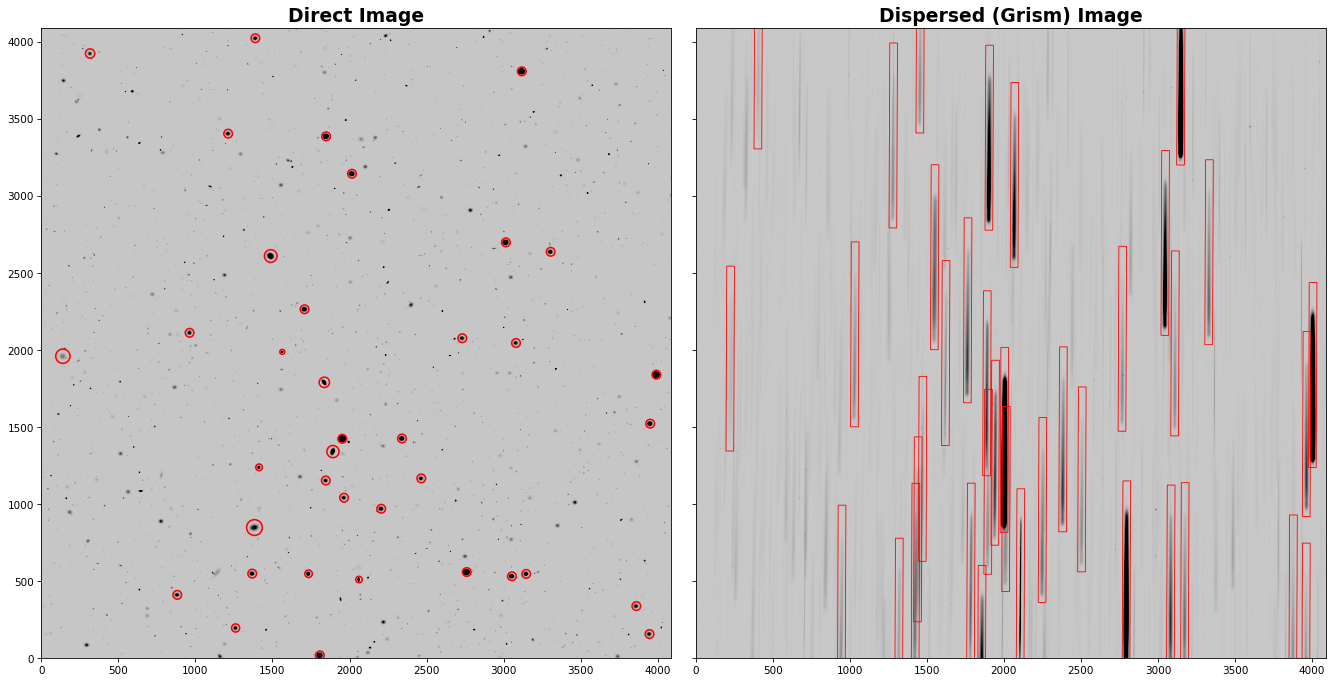

In [3]:
### Setup the figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9), dpi=75, sharex=True, sharey=True, tight_layout=True)

### Plot the direct image
vmin, vmax = get_vmin_vmax(direct_img)
ax1.imshow(
    direct_img,
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.Greys,
    origin="lower",
)
ax1.set_title("Direct Image", fontsize=18, fontweight=600)

### Plot the grism image
vmin, vmax = get_vmin_vmax(grism_img)
ax2.imshow(
    grism_img,
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.Greys,
    origin="lower",
)
ax2.set_title("Dispersed (Grism) Image", fontsize=18, fontweight=600)

### Overlay the source positions in the direct image
for i, entry in enumerate(catalog[catalog["mag_ROMAN_WFI_NIR_F146"] < 18]): # only show the bright objects
    ax1.add_patch(
        Circle(
            (entry["X_IMAGE"], entry["Y_IMAGE"]),
            radius=entry["A_IMAGE"] * 3.5,
            facecolor="none",
            edgecolor="r",
            lw=1.5,
        )
    )
    bbox = [50, 1200]
    ax2.add_patch(Rectangle((entry["X_GRISM"]-bbox[0]/2, entry["Y_GRISM"]-bbox[1]/2), *bbox, angle=entry["THETA_GRISM"]-90, lw=0.8, facecolor="none", edgecolor='r'))
    
ax1.set_xlim(0, grism_img.shape[0])
ax1.set_ylim(0, grism_img.shape[1]);

### Cutout a 2D spectrum

Let's now pick an object of interest and make a cutout of its 2D spectrum from the dispersed image. We will also rotate the vertical spectra by its tilt + 90 degrees for the visualization, making it easier to plot them.

**Note:** We are simplifying significantly here this process of extracting a 2D spectral cutout. The spectral traces are not necessarily straight and typically require higher-order rectification. For the purposes of this exercise, we are skipping this step and only considering a simple rotational transformation for the spectra. Also, we are using SciPy's `rotate` function here since it is quick and convenient, however, please note that this does not necessarily conserve flux which is important for proper scientific measurements.

First, we write a function to perform our 2D extraction since this will be utilized again later.

In [4]:
def extract_2D_spectrum(xpix, ypix, theta, size_spatial, grism_img, grism_err, size_wavelength=1200):
    """
    Cutout a 2D spectrum at the desired position for a given size (spatial and spectral dimensions)
    This assumes the spectra are aligned along the y-axis of the dispersed image
    The recommended size in the wavelength dimension is 1200 px
    """
    ### Define the extraction box
    size = [size_spatial, size_wavelength]
    
    ### Use astropy's Cutout2D
    ### Fill value is set to 0 to avoid issues with rotate
    flux2D = cutout_image(image=grism_img, position=(xpix, ypix), size=size[::-1], fill_value=0)
    ferr2D = cutout_image(image=grism_err, position=(xpix, ypix), size=size[::-1], fill_value=0)
    
    ### Rotate the vertial spectral just for plotting purposes
    flux2D = rotate(flux2D, theta)
    ferr2D = rotate(ferr2D, theta)

    return flux2D, ferr2D

Let's pick a bright star as our test object -- e.g., ID# 197462 in the catalog.

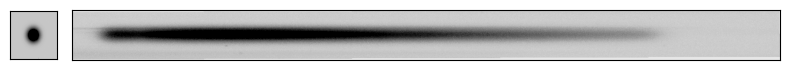

In [5]:
### Let's choose an object
entry = catalog[catalog["SOURCE_ID"]==197462][0]

### Cutout the 2D spectrum
flux2D, ferr2D = extract_2D_spectrum(entry["X_GRISM"], entry["Y_GRISM"], entry["THETA_GRISM"], size_spatial=entry["A_IMAGE"] * 10, grism_img=grism_img, grism_err=grism_err)

### Also cutout a direct image stamp
stamp = rotate(cutout_image(image=direct_img, position=(entry["X_IMAGE"], entry["Y_IMAGE"]), size=flux2D.shape[0]), 90)

### Make a quick plot
fig, axes = plt.subplots(1, 2, figsize=(8, 2), width_ratios=[1, 15], dpi=100, tight_layout=True)

vmin, vmax = get_vmin_vmax(stamp)
axes[0].imshow(stamp, origin="lower", vmin=vmin, vmax=vmax, cmap=plt.cm.Greys)

vmin, vmax = get_vmin_vmax(flux2D)
axes[1].imshow(flux2D, origin="lower", vmin=vmin, vmax=vmax, cmap=plt.cm.Greys)

for axis in axes:
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)

Now that we have a 2D cutout of the spectrum, we need to assign wavelength information.

### Setup the wavelength array

Recall that the provided position for the spectral mapping traces to **1.55 micron** and the spectral dispersion for the Roman grism spectrum is **11 Angs/pixel** (approximately; see caveats above). With this information we can define a wavelength axis for the extracted spectrum. 

In [6]:
def get_wavelength_info(flux2D):
    """
    Setup spatial and wavelength coordinate arrays
    """
    grism_dispersion = 0.0011 # micron / px (approximately)
    grism_zeropoint = 1.55 # micron

    idx2D, idy2D = np.indices(flux2D.shape)
    idx2D = idx2D - flux2D.shape[0] / 2
    idy2D = idy2D - flux2D.shape[1] / 2
    
    wave2D = idy2D * grism_dispersion + grism_zeropoint

    return idx2D, wave2D

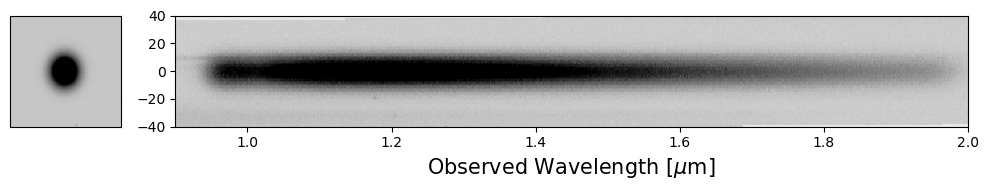

In [7]:
### Make a quick plot
fig, axes = plt.subplots(1, 2, figsize=(10, 2), width_ratios=[1, 7], dpi=100, tight_layout=True)

vmin, vmax = get_vmin_vmax(stamp)
axes[0].imshow(stamp, origin="lower", vmin=vmin, vmax=vmax, cmap=plt.cm.Greys)
axes[0].xaxis.set_visible(False)
axes[0].yaxis.set_visible(False)

vmin, vmax = get_vmin_vmax(flux2D)
idx2D, wave2D = get_wavelength_info(flux2D=flux2D)
axes[1].pcolormesh(wave2D, idx2D, flux2D, vmin=vmin, vmax=vmax, cmap=plt.cm.Greys)

axes[1].set_xlim(0.9, 2.0)
axes[1].set_ylim(-40, 40)
axes[1].set_xlabel("Observed Wavelength [$\\mu$m]", fontsize=15);

Now, we have a 2D spectrum and we can move to extracting the 1D.

### Box Extraction

The simplest and most straightforward way to extract a 1D spectrum from our 2D cutout is to use "Box extraction", which simply defines a window around the central trace and sums up the flux along the spatial dimension. The box window we use has a significant impact on the extracted spectrum -- we want this window to be large enough to capture all the flux from the source, but not too large so as to include excessive amounts of noise which degrades the quality of the 1D spectrum. We will explore the optimal extraction a bit later, but for now we can use the size of the object as measured from the direct image to define our extraction window. Let's use the semi-major axis length from the catalog scaled by a scalar factor to see how the size of the window affects the extracted 1D spectrum.

In [8]:
def do_box_extraction(idx2D, wave2D, flux2D, ferr2D, extract_size):
    """
    Perform a box extraction
    """
    cond = np.abs(idx2D[:,0]) < extract_size / 2
    wave1D = np.nanmean(wave2D, axis=0)
    flux1D = np.nansum(flux2D[cond, :], axis=0)
    ferr1D = np.sqrt(np.nansum(ferr2D[cond, :]**2, axis=0))
    
    return wave1D, flux1D, ferr1D

Let's use a range of box sizes for the 1D extraction and see how it performs for our object of interest.

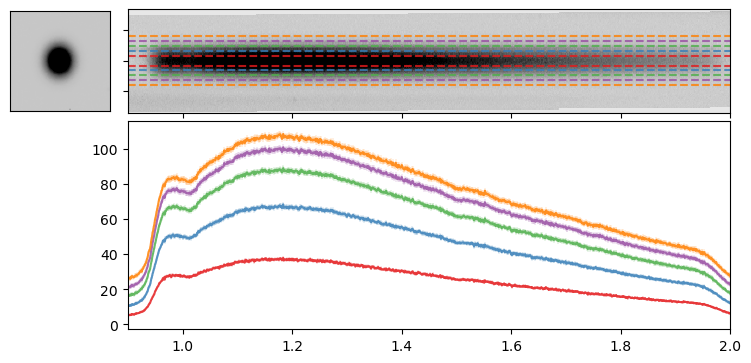

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(8, 4), width_ratios=[1, 6], height_ratios=[1, 2], dpi=100)
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.15, wspace=0.05, hspace=0.05)
axes = axes.flatten()
axes[2].set_visible(False)

# Plot the direct image stamp
vmin, vmax = get_vmin_vmax(stamp)
axes[0].imshow(stamp, origin="lower", vmin=vmin, vmax=vmax, cmap=plt.cm.Greys)
axes[0].xaxis.set_visible(False)
axes[0].yaxis.set_visible(False)

# Plot the 2D spectrum
vmin, vmax = get_vmin_vmax(flux2D)
axes[1].pcolormesh(wave2D, idx2D, flux2D, vmin=vmin, vmax=vmax, cmap=plt.cm.Greys)
axes[1].set_xlim(0.9, 2.0)
[label.set_visible(False) for label in axes[1].get_yticklabels() + axes[1].get_xticklabels()]

color_cycle = cycle(plt.cm.Set1.colors)
for factor in [1, 2, 3, 4, 5]:
    color = next(color_cycle)
    wave1D, flux1D, ferr1D = do_box_extraction(idx2D=idx2D, wave2D=wave2D, flux2D=flux2D, ferr2D=ferr2D, extract_size=entry["A_IMAGE"]*factor)
    axes[3].errorbar(wave1D, flux1D, yerr=ferr1D, marker='o', color=color, lw=1.5, mew=0, markersize=0, elinewidth=0.2, capsize=0, alpha=0.8)
    axes[1].hlines([-entry["A_IMAGE"]*factor/2, entry["A_IMAGE"]*factor/2], *axes[1].get_xlim(), color=color, lw=1.5, ls='--', alpha=0.8)
axes[3].set_xlim(axes[1].get_xlim());

The extraction box size is important -- if it is too small, one will miss out on flux from the real source, or if it too large, one can include too much noise and thus lower the overall quality of the resulting spectrum. Thus, we turn to the optimal extraction method.

### Optimal Extraction

[Horne (1986, PASP, 98, 609)](https://ui.adsabs.harvard.edu/abs/1986PASP...98..609H/abstract) provides an algorithm to optimally extract a 1D spectrum. For this algorithm, we require a 1D light profile of the source (in the spatial dimension). For this, we will use the direct image associated with the dispersed/grism image and make a cutout of the source that matches the extracted 2D spectrum. 

First, let's write up a quick function to implement the Horne+86 algorithm.

In [10]:
def do_optimal_extraction(idx2D, wave2D, flux2D, ferr2D, stamp):
    """
    Performs optimal extraction following Horne+86
    """
    # Generate a 1D light profile for the source from the direct image
    stamp = stamp - np.median(stamp)
    prof1D = np.nansum(stamp, axis=1)
    prof1D = prof1D / np.sum(prof1D)
    prof2D = np.repeat(prof1D, flux2D.shape[1]).reshape(len(prof1D), flux2D.shape[1])

    # Apply some basic masking
    mask = ~np.isfinite(flux2D) | ~np.isfinite(ferr2D) | (ferr2D<=0)
    flux2D = np.ma.masked_array(flux2D, mask=mask)
    ferr2D = np.ma.masked_array(ferr2D, mask=mask)

    # Compute the relevant terms for the Horne+86 algorithm
    ivar2D = 1 / ferr2D**2
    num2D = ivar2D * prof2D * flux2D
    den2D = ivar2D * prof2D**2

    # Compute the final wavelength and flux arrays
    wave1D = np.mean(wave2D, axis=0)
    flux1D = np.ma.sum(num2D, axis=0) / np.ma.sum(den2D, axis=0)
    ferr1D = np.ma.sqrt(1 / np.ma.sum(den2D, axis=0))
    
    return wave1D, flux1D.filled(np.nan), ferr1D.filled(np.nan)

Let's apply this optimal extraction to our object of interest and compare with the results from box extraction.

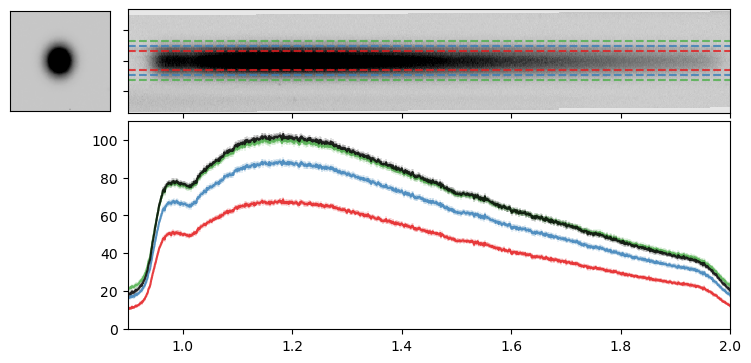

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(8, 4), width_ratios=[1, 6], height_ratios=[1, 2], dpi=100)
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.15, wspace=0.05, hspace=0.05)
axes = axes.flatten()
axes[2].set_visible(False)

# Plot the direct image stamp
vmin, vmax = get_vmin_vmax(stamp)
axes[0].imshow(stamp, origin="lower", vmin=vmin, vmax=vmax, cmap=plt.cm.Greys)
axes[0].xaxis.set_visible(False)
axes[0].yaxis.set_visible(False)

# Plot the 2D spectrum
vmin, vmax = get_vmin_vmax(flux2D)
axes[1].pcolormesh(wave2D, idx2D, flux2D, vmin=vmin, vmax=vmax, cmap=plt.cm.Greys)
axes[1].set_xlim(0.9, 2.0)
[label.set_visible(False) for label in axes[1].get_yticklabels() + axes[1].get_xticklabels()]

color_cycle = cycle(plt.cm.Set1.colors)
for factor in [2, 3, 4]:
    color = next(color_cycle)
    wave1D, flux1D, ferr1D = do_box_extraction(idx2D=idx2D, wave2D=wave2D, flux2D=flux2D, ferr2D=ferr2D, extract_size=entry["A_IMAGE"]*factor)
    axes[3].errorbar(wave1D, flux1D, yerr=ferr1D, marker='o', color=color, lw=1.5, mew=0, markersize=0, elinewidth=0.2, capsize=0, alpha=0.8)
    axes[1].hlines([-entry["A_IMAGE"]*factor/2, entry["A_IMAGE"]*factor/2], *axes[1].get_xlim(), color=color, lw=1.5, ls='--', alpha=0.8)

wave1D, flux1D, ferr1D = do_optimal_extraction(idx2D=idx2D, wave2D=wave2D, flux2D=flux2D, ferr2D=ferr2D, stamp=stamp)
axes[3].errorbar(wave1D, flux1D, yerr=ferr1D, color='k', marker='o', lw=1.5, mew=0, markersize=0, elinewidth=0.2, capsize=0, alpha=0.8)

axes[3].set_xlim(axes[1].get_xlim());

##### Masking neighboring sources in direct cutouts

For the direct stamp used as part of optimal extraction, it is imperative that other neighboring sources are properly masked before generating the 1D light profile for the source otherwise the extracted 1D spectrum will not be accurate. For this, we will implement a quick photutils source detection just for the stamp and use it to mask out other sources in the stamp. 

While our test object does not require this treatment since there are no nearby bright sources, we will need to do this for other sources showcased below.

In [12]:
grism_img_thresh = np.std(grism_img)
grism_img_skybkg = np.median(grism_img) / 2

def mk_segmented_stamp(data, skybkg=grism_img_skybkg, thresh=grism_img_thresh*0.8):

    if skybkg is None:
        skybkg = np.median(data)
    if thresh is None:
        thresh = np.std(data) / 2
    
    segm = detect_sources(data-skybkg, thresh, npixels=5).data

    data_segm = data.copy()
    idx = [i // 2 for i in segm.shape]
    data_segm[(segm!=segm[*idx]) & (segm>0)] = 0
    return data_segm

### Full Workflow: Grism image to extracted 1D spectrum

Now that we have demonstrated all the steps to go from a full Roman dispersed grism image down to the 1D spectrum for a select object, let's combine all the steps into a single workflow that does the full 1D extraction and apply it multiple sources.

In [13]:
def do_full_extraction(entry, direct_img, grism_img, grism_err, size_factor=10, box_size_factor=None, plot=True):
    """
    Performs the full 1D spectral extraction workflow for a given object provided as a row from the catalog
    Requires X_IMAGE, Y_IMAGE, A_IMAGE, X_GRISM, Y_GRISM columns from the catalog
    Also requires the direct and grism images
    Optionally produces plots
    """
    # Start by extracting the 2D spectrum
    size_spatial = np.clip(entry["A_IMAGE"] * size_factor, 10, 500)
    flux2D, ferr2D = extract_2D_spectrum(entry["X_GRISM"], entry["Y_GRISM"], entry["THETA_GRISM"], size_spatial=size_spatial, grism_img=grism_img, grism_err=grism_err)
    
    # Generate a stamp for the source from the direct image and also mask other objects in the stamp
    stamp = rotate(cutout_image(image=direct_img, position=(entry["X_IMAGE"], entry["Y_IMAGE"]), size=flux2D.shape[0]), 90)
    stamp_masked = mk_segmented_stamp(data=stamp)

    # Generate the wavelength info
    idx2D, wave2D = get_wavelength_info(flux2D=flux2D)

    # Generate the 1D spectrum with optimal extraction
    wave1D, flux1D, ferr1D = do_optimal_extraction(idx2D=idx2D, wave2D=wave2D, flux2D=flux2D, ferr2D=ferr2D, stamp=stamp_masked)

    # (optionally) Generate a plot to show of the spectrum and also box extraction results
    if plot:
        # Setup the subplots
        fig, axes = plt.subplots(2, 2, figsize=(12, 4), width_ratios=[1, 6], height_ratios=[2, 3], dpi=100)
        fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.15, wspace=0.05, hspace=0.05)
        axes = axes.flatten()
        axes[2].set_visible(False)
            
        # Plot the direct image stamp
        vmin, vmax = get_vmin_vmax(stamp_masked)
        axes[0].imshow(stamp_masked, origin="lower", vmin=vmin, vmax=vmax, cmap=plt.cm.Greys)
        axes[0].xaxis.set_visible(False)
        axes[0].yaxis.set_visible(False)
            
        # Plot the 2D spectrum
        vmin, vmax = get_vmin_vmax(flux2D[int(flux2D.shape[0] / 4) : int(flux2D.shape[0] * 3 / 4), :])
        axes[1].pcolormesh(wave2D, idx2D, flux2D, vmin=vmin, vmax=vmax, cmap=plt.cm.Greys)
        axes[1].set_xlim(0.9, 1.9)
        [label.set_visible(False) for label in axes[1].get_yticklabels() + axes[1].get_xticklabels()]
        
        # Plot box extraction
        color_cycle = cycle(plt.cm.Set1.colors)
        _flux1D_for_ylim = []
        if box_size_factor is not None:
            for factor in np.atleast_1d(box_size_factor):
                color = next(color_cycle)
                _wave1D, _flux1D, _ferr1D = do_box_extraction(idx2D=idx2D, wave2D=wave2D, flux2D=flux2D, ferr2D=ferr2D, extract_size=entry["A_IMAGE"]*factor)
                axes[3].errorbar(_wave1D, _flux1D, yerr=_ferr1D, marker='o', lw=1.5, mew=0, markersize=0, elinewidth=0.2, capsize=0, alpha=0.8)
                axes[1].hlines([-entry["A_IMAGE"]*factor/2, entry["A_IMAGE"]*factor/2], *axes[1].get_xlim(), color=color, lw=1.5, ls='--', alpha=0.8)
                _flux1D_for_ylim = np.append(_flux1D_for_ylim, _flux1D[(np.abs(wave1D-1.5) < 0.4) & (_flux1D > 0)])
        
        # Plot Optical extraction
        axes[3].errorbar(wave1D, flux1D, yerr=ferr1D, color='k', marker='o', lw=1.5, mew=0, markersize=0, elinewidth=0.2, capsize=0, alpha=0.8)
        axes[3].set_xlim(axes[1].get_xlim())

        # Plot decorations and axis limits
        flux1D_for_ylim = flux1D[(np.abs(wave1D-1.5) < 0.4) & (flux1D > 0)]
        flux1D_for_ylim = np.append(flux1D_for_ylim, _flux1D_for_ylim)
        ylim = np.nanpercentile(flux1D_for_ylim, [1, 100])
        axes[3].set_ylim(0, ylim[1]*1.3)
        axes[3].set_ylabel("Flux [DN/s]", fontsize=14)
        axes[3].set_xlabel("Wavelength [$\\mu$m]", fontsize=14)
        axes[3].text(0.995, 0.98, f"ID#{entry['SOURCE_ID']:d}", va="top", ha="right", color="k", fontsize=18, transform=axes[3].transAxes)

    return {"stamp": stamp, 
            "flux2D": flux2D, "ferr2D": ferr2D, "idx2D": idx2D, "wave2D": wave2D, 
            "wave1D": wave1D, "flux1D": flux1D, "ferr1D": ferr1D}

### Examples of bright stars

Let's start with some examples of bright stars included in the simulation. Here is a short list: 46656, 197387, 197396, 197413, 197418, 197462, 197484, 197503, 197585, 197590, 197592, 197594

/home/vihangmehta/Software/Miniconda/lib/python3.12/site-packages/numpy/ma/core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


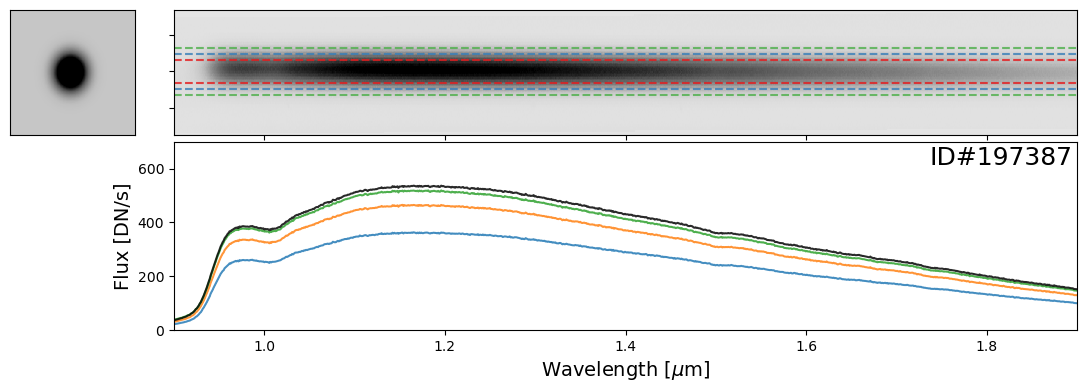

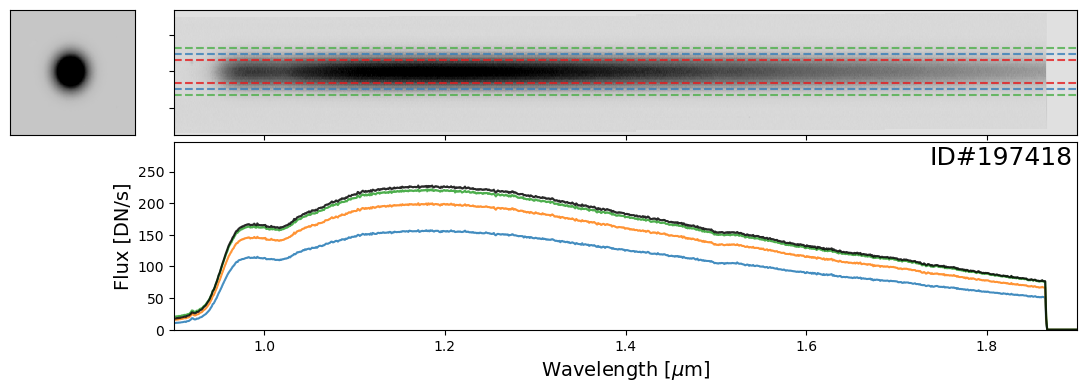

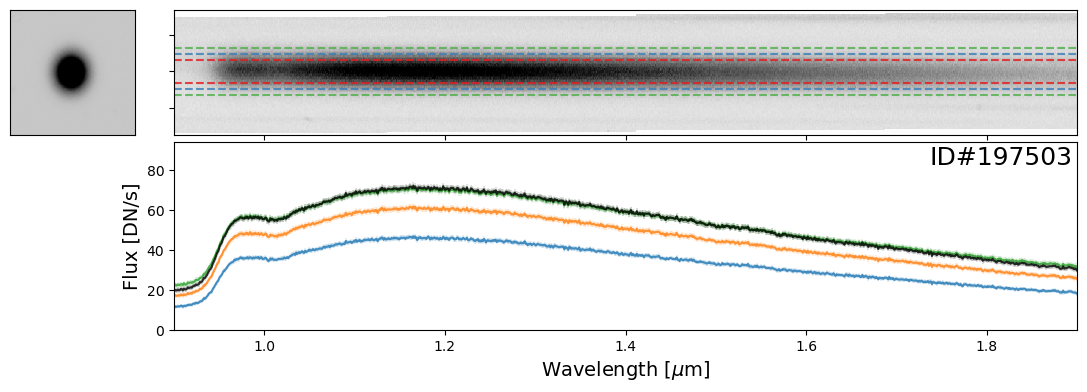

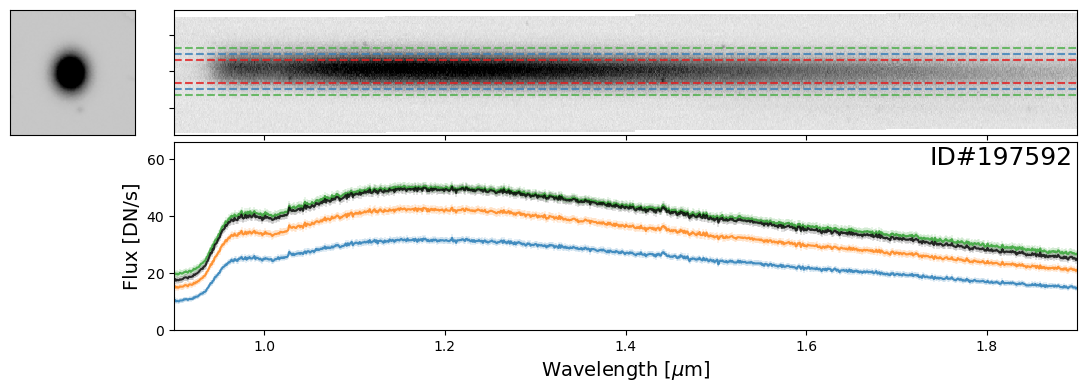

In [14]:
star_IDs = [197387, 197396, 197413, 197418, 197462, 197484, 197503, 197585, 197590, 197592, 197594]
for star_ID in star_IDs[::3]:   # Only showing a subset; increase as needed
    entry = catalog[catalog["SOURCE_ID"]==star_ID][0]
    do_full_extraction(entry, direct_img, grism_img, grism_err, box_size_factor=[2, 3, 4], plot=True)

### Examples of galaxies

Now let's take a look at some galaxies. Here you can experiment with whichever objects you want from the source catalog. For showcase purposes, we have provided a few select examples that highlight interesting spectral features.

/home/vihangmehta/Software/Miniconda/lib/python3.12/site-packages/numpy/ma/core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


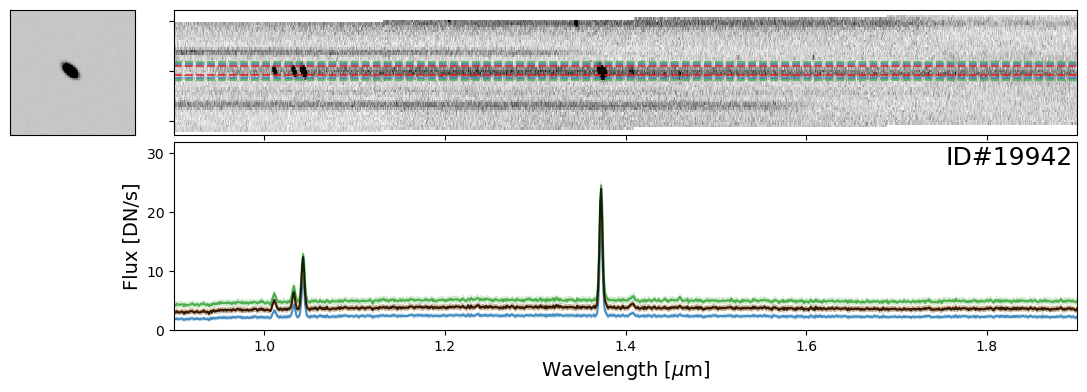

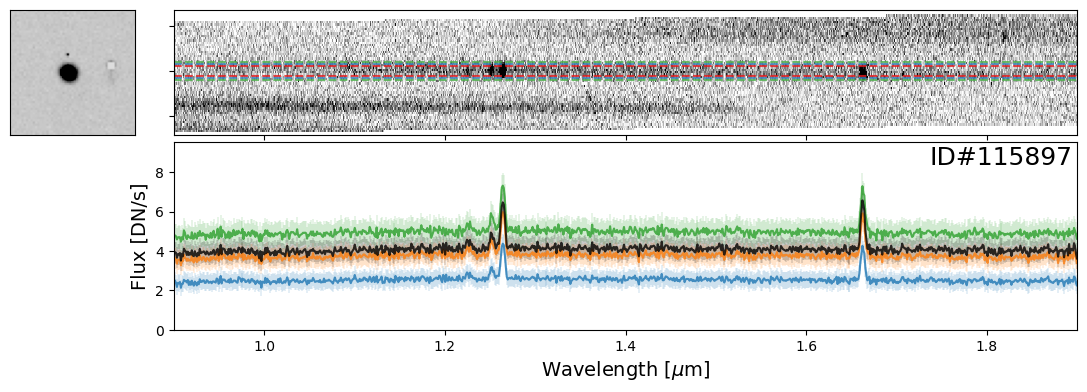

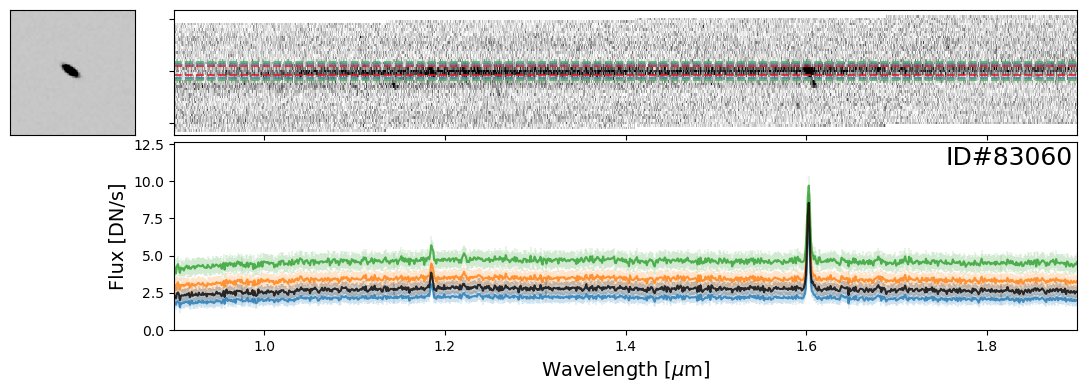

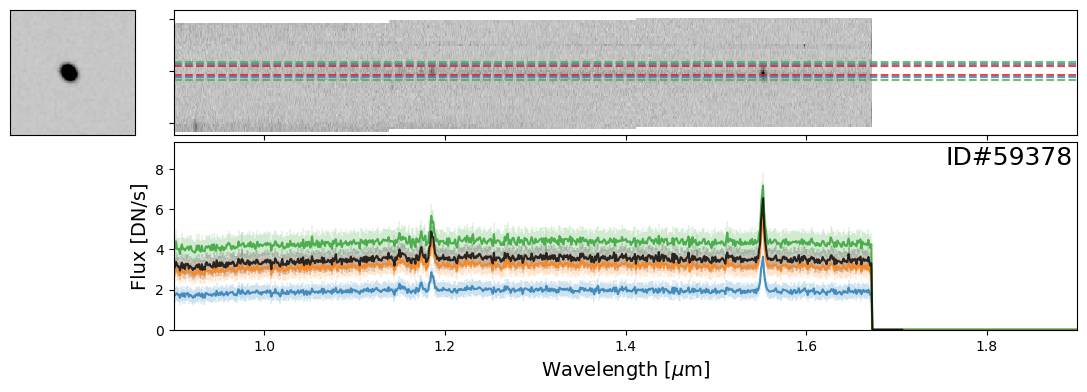

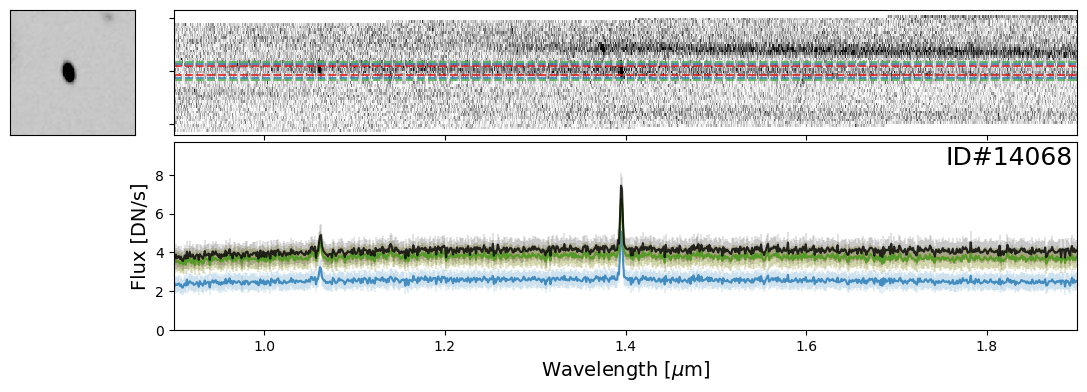

In [15]:
galaxy_IDs = [19942, 115897, 83060, 59378, 14068]
for source_ID in galaxy_IDs:
    entry = catalog[catalog["SOURCE_ID"]==source_ID][0]
    do_full_extraction(entry, direct_img, grism_img, grism_err, size_factor=25, box_size_factor=[2, 3, 4], plot=True)

#### Examples of nearby emission line galaxies

Here are a couple examples of emission line galaxies that are close enough to where you can visbily see the emission lines from the neighboring object in the extracted 2D spectrum.

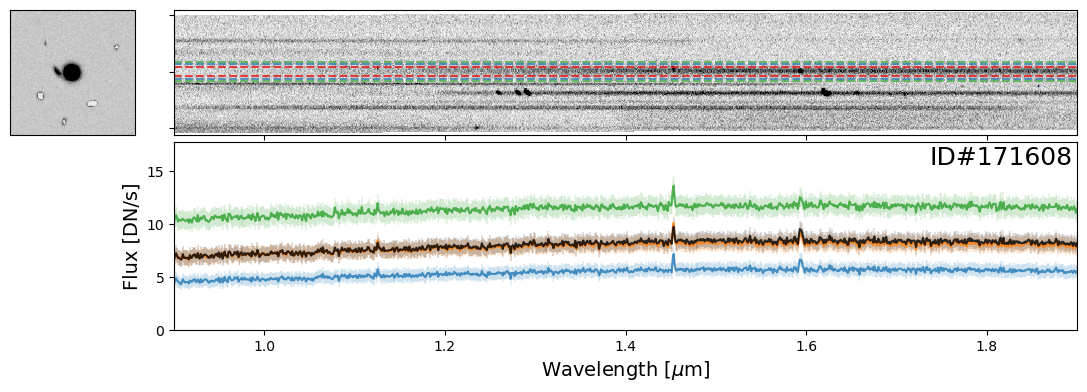

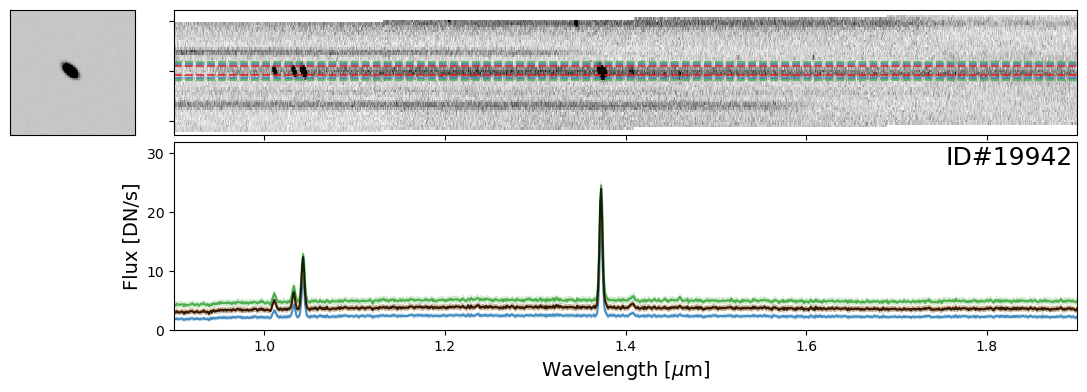

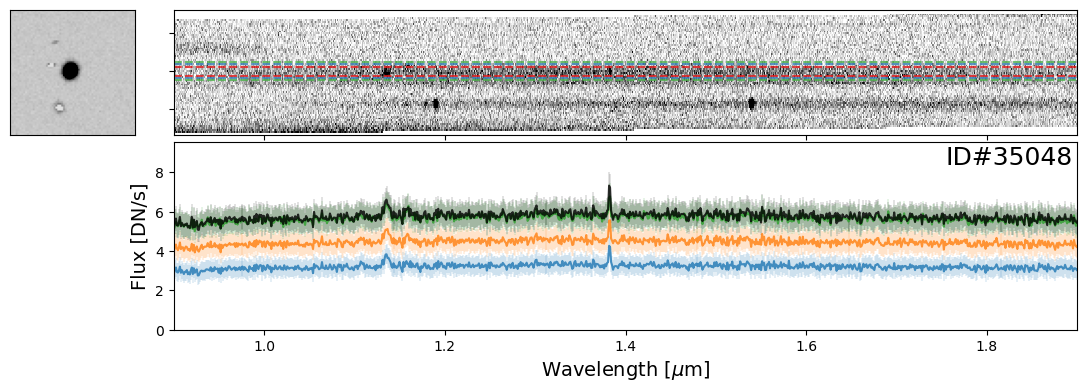

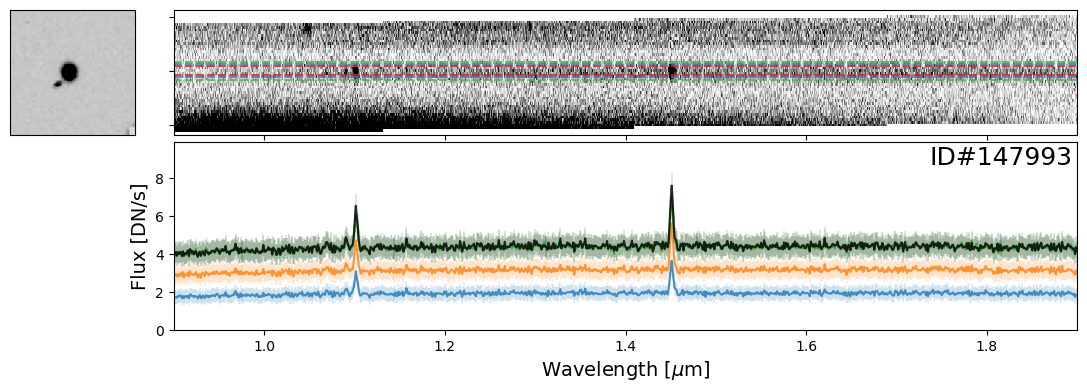

In [21]:
pairs_IDs = [171608, 19942, 35048, 147993]
for source_ID in pairs_IDs:
    entry = catalog[catalog["SOURCE_ID"]==source_ID][0]
    do_full_extraction(entry, direct_img, grism_img, grism_err, size_factor=25, box_size_factor=[2, 3, 4], plot=True)

#### Example of overlapping spectra

Here is an example of two spectra, one from a star and another from a bright, high-redshift emission line galaxy, that happen to overlap with each other.
- The star ID#197738
- The galaxy ID#166231


In these types of scenarios, it is imperative to perform a "decontamination" for each of the spectra to accurately recover the true flux of the individual sources. This is a non-trivial process and this functionality will be available in the Roman GDPS pipeline.

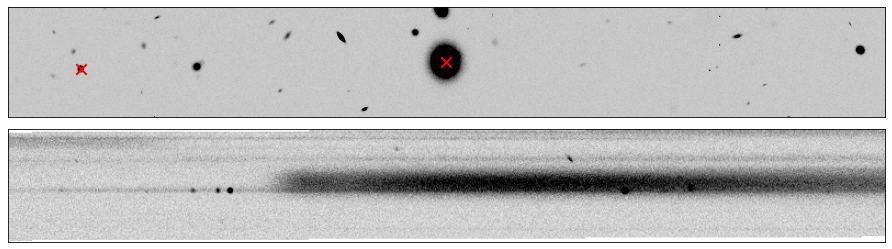

In [27]:
entry_str = catalog[catalog["SOURCE_ID"]==197738][0]
entry_gal = catalog[catalog["SOURCE_ID"]==166231][0]

stamp = rotate(cutout_image(image=direct_img, position=(entry_str["X_IMAGE"], entry_str["Y_IMAGE"]), size=[800, 100]), 90)
flux2D = rotate(cutout_image(image=grism_img, position=(entry_str["X_GRISM"], entry_str["Y_GRISM"]-400), size=[800, 100]), entry_str["THETA_GRISM"])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,3.5), dpi=75, tight_layout=True)

vmin, vmax = get_vmin_vmax(stamp)
ax1.imshow(stamp, origin="lower", vmin=vmin, vmax=vmax, cmap=plt.cm.Greys)
ax1.scatter(stamp.shape[1]/2 - 1, stamp.shape[0]/2 - 1, color="r", marker="x", lw=2, s=100)
ax1.scatter(stamp.shape[1]/2 - 1 + (entry_gal["Y_IMAGE"]-entry_str["Y_IMAGE"]), 
            stamp.shape[0]/2 - 1 - (entry_gal["X_IMAGE"]-entry_str["X_IMAGE"]), color="r", marker="x", lw=2, s=100)

vmin, vmax = get_vmin_vmax(flux2D)
ax2.imshow(flux2D, origin="lower", vmin=vmin, vmax=vmax, cmap=plt.cm.Greys)

for ax in [ax1, ax2]:
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

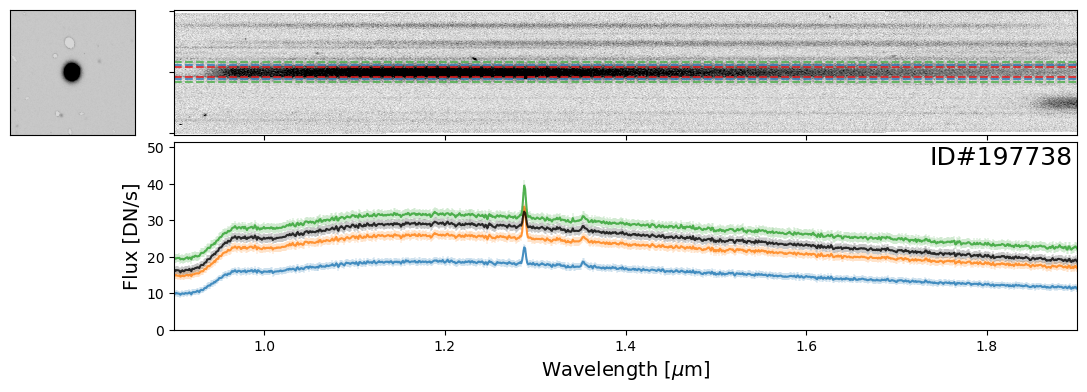

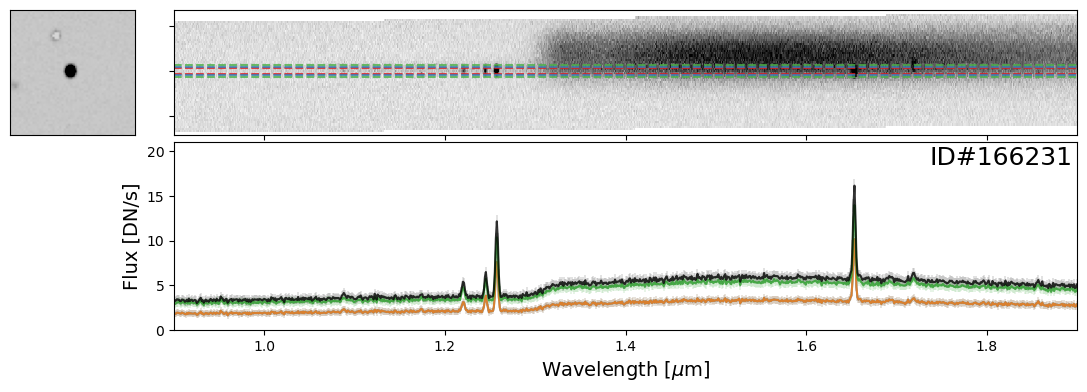

In [18]:
do_full_extraction(entry_str, direct_img, grism_img, grism_err, size_factor=25, box_size_factor=[2, 3, 4], plot=True)
do_full_extraction(entry_gal, direct_img, grism_img, grism_err, size_factor=40, box_size_factor=[2, 3, 4], plot=True);

The extracted 1D spectra produced as part of this notebook are in image units (DN/sec). To convert to science units, one still needs to apply the grism sensitivity function. This is left as an exercise for the users. 

# Summary

Through this notebook, we have illustrated how to go from a full Roman grism image down to the extracted 1D spectrum for individual objects. While there are various caveats, assumptions, and simplifications (as noted) made along the way, this is an accurate demonstration of the overall process. 

Potential next steps to explore: 
- visualizing the extracted 1D spectra with a tool such as SpecViz
- measuring the redshifts of the objects using their emission line (e.g., via cross-correlation)
- applying grism sensitivity function to convert the spectra to science units

As mentioned, this exercise does not showcase the full functionality of the GDPS pipeline, just a subset of it. You can read further on the detailed plans for the GDPS pipeline [here](https://roman.gsfc.nasa.gov/science/roses/GDPSforROSES.pdf]).